In [1]:
import array
import random


class Model(object):

    @property
    def n_dimensions(self):
        raise NotImplementedError("")

    @property
    def n_parameters(self):
        raise NotImplementedError("")

    def __init__(self):

        self._coordinates = array.array(
            'f',
            bytearray(4*self.n_dimensions)
        )

        self._initial_coordinates = array.array(
            'f',
            bytearray(4*self.n_dimensions)
        )

        self._derivatives = array.array(
            'f',
            bytearray(4*self.n_dimensions)
        )

        self._parameters = array.array(
            'f',
            bytearray(4*self.n_parameters)
        )

    def take_step(self) -> None:
        raise NotImplementedError("")

    def set_initial_coordinates(self):
        print("OOPS")
        for i in range(self.n_dimensions):
            self._initial_coordinates[i] = self._coordinates[i]

    def reset(self) -> None:
        for i in range(self.n_dimensions):
            self._coordinates[i] = self._initial_coordinates[i]


class LorenzSystem(Model):
    """
    Parameters
    ----------
    timestep
        The size of the step (in time units) to take.
        Default of 0.005 was determined by experimentation only.
    """
    def reset(self) -> None:
        super().reset()
        if self._random_factor:
            for i in range(self.n_dimensions):
                self._coordinates[i] += self._random_factor * random.random()
    
    
    @property
    def n_dimensions(self):
        return 3

    @property
    def n_parameters(self):
        return 3

    def __init__(self,
                 x: float = 0.9,
                 y: float = 0.0,
                 z: float = 0.0,
                 sigma : float = 10.0,
                 rho: float = 28,
                 beta: float = 8/3,
                 timestep: float = 0.005,
                 random_factor=None):

        super().__init__()

        self._coordinates = [x, y, z]
        self._initial_coordinates = [x, y, z]
        self._parameters = [sigma, rho, beta]

        self._timestep = timestep

        self._random_factor = random_factor

        self._crossed_zero = False

    def __compute_derivatives(self):
        """Determine the partial derivatives at the current coordinates."""
        self._derivatives = [
            self._parameters[0] * (self._coordinates[1] - self._coordinates[0]),
            self._coordinates[0] * (self._parameters[1] - self._coordinates[2]) - self._coordinates[1],
            (self._coordinates[0] * self._coordinates[1]) - (self._parameters[2] * self._coordinates[2])
        ]

    def take_step(self) -> None:
        """Determine the value of f(t_n+1, x, y, z) at the next timestep.

        This stepper uses the most basic possible scheme to integrate
        the ODEs of the system; Euler's method. This only requires a
        single evaluation of f(t, x, y, z) so is cheap, but is only accurate
        on the order of the square of the timestep.

        Parameters
        ----------

        """
        previous_x = self._coordinates[0]

        self.__compute_derivatives()

        for i in range(self.n_dimensions):
            self._coordinates[i] += self._derivatives[i] * self._timestep

        if (previous_x * self._coordinates[0]) < 0:
            self._crossed_zero = True
        else:
            self._crossed_zero = False

In [2]:
class Looper(object):
    """A looper for a model."""
    def __init__(self,
                 model: Model,
                 looping: bool = False):

        self._model = model
        self._looping = looping

        self._counter = 0
        self._num_steps = None

    def set_initial_coordinates(self):
        self.reset()
        self._model.set_initial_coordinates()

    def reset(self):
        self._counter = 0

    def start_looping(self):
        """Start looping the model.

        On loop start, the current position of the model will be used as the
        final position for the loop. To enable this behaviour, the number of
        steps taken since the start point was set is saved, and the counter is
        reset to zero. Turning on the looping indicator means that the method
        taking model steps will check if the counter hits the desired number of
        steps and restart.
        """
        self._looping = True
        self._num_steps = self._counter
        self.reset()
        self._model.reset()


    def stop_looping(self):
        """Stop looping the model.

        On stopping the loop, the start position is retained but the final
        position is not kept, since it is set when the loop begins. The counter
        continues to count from the start point in case the looping is started
        again, so that the start point is kept.
        """
        self._looping = False
        self._num_steps = None

    def take_step(self):
        """Take a step along the model's trajectory.

        If the system is not being looped, this method just takes a step on the
        model trajectory and increments the counter. If the number of steps in
        the loop has been reached, the looper is at the end of its loop and so
        moves the system back to its initial coordinates and resets the
        counter. At the end of a loop, the "step" is to return to the model's
        initial position, so take_step is not called as this would result in a
        double step in a single cycle.
        """
        if self._looping:
            if self._counter == self._num_steps:
                self._model.reset()
                self.reset()
                return

        self._model.take_step()
        self._counter += 1

In [3]:
class Looper(object):
    """A looper for models."""
    def __init__(self,
                 models: list,
                 looping: bool = False):

        self._models = models
        self._looping = looping

        self._counter = 0
        self._num_steps = None

    def set_initial_coordinates(self):
        self.reset()
        for model in self._models:
            model.set_initial_coordinates()

    def reset(self):
        self._counter = 0

    def start_looping(self):
        """Start looping the model.

        On loop start, the current position of the model will be used as the
        final position for the loop. To enable this behaviour, the number of
        steps taken since the start point was set is saved, and the counter is
        reset to zero. Turning on the looping indicator means that the method
        taking model steps will check if the counter hits the desired number of
        steps and restart.
        """
        self._looping = True
        self._num_steps = self._counter
        self.reset()
        for model in self._models:
            model.reset()


    def stop_looping(self):
        """Stop looping the model.

        On stopping the loop, the start position is retained but the final
        position is not kept, since it is set when the loop begins. The counter
        continues to count from the start point in case the looping is started
        again, so that the start point is kept.
        """
        self._looping = False
        self._num_steps = None

    def take_step(self):
        """Take a step along the model's trajectory.

        If the system is not being looped, this method just takes a step on the
        model trajectory and increments the counter. If the number of steps in
        the loop has been reached, the looper is at the end of its loop and so
        moves the system back to its initial coordinates and resets the
        counter. At the end of a loop, the "step" is to return to the model's
        initial position, so take_step is not called as this would result in a
        double step in a single cycle.
        """
        if self._looping:
            if self._counter == self._num_steps:
                for model in self._models:
                    model.reset()

                self.reset()
                return

        for model in self._models:
            model.take_step()

        self._counter += 1

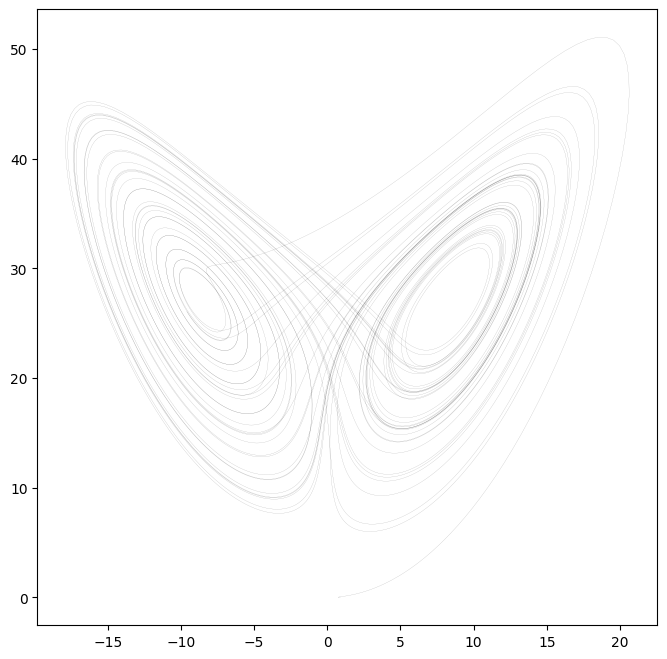

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


N = 10000
n_plot = 0

lorenz_system = LorenzSystem()

xyz_values = np.empty(shape=(N, 3))
xyz_values[0, :] = lorenz_system._coordinates

for i in range(1, N):
    lorenz_system.take_step()
    xyz_values[i, :] = lorenz_system._coordinates

f = plt.plot(xyz_values[n_plot:, 0], xyz_values[n_plot:, 2], lw=0.1, c="gray")
# f = plt.plot(xyz_values[n_plot:, 0], xyz_values[n_plot:, 1], lw=0.1, c="teal")
# f = plt.plot(xyz_values[n_plot:, 1], xyz_values[n_plot:, 2], lw=0.1, c="orange")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 8)

# Looping without Sensitivity to Initial Conditions

The system can be looped without making use of the property of sensitivity to initial conditions. To achieve this, no perturbation of the initial coordinates of the system is carried out at the start of the loop. Loops of this kind will repeat indefinitely until looping is turned off, unless the start point is altered (which will by definition shorten the loop).

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

N = 10000
n_plot = 0

lorenz_system = LorenzSystem()
looper = Looper(models=[lorenz_system])

xyz_values = np.empty(shape=(N, 3))
xyz_values[0, :] = lorenz_system._coordinates

for i in range(0, 2000):
    xyz_values[i, :] = lorenz_system._coordinates
    looper.take_step()

looper.start_looping()
for i in range(2000, 6000):
    xyz_values[i, :] = lorenz_system._coordinates
    looper.take_step()

looper.stop_looping()
for i in range(6000, N):
    xyz_values[i, :] = lorenz_system._coordinates
    looper.take_step()

# print(xyz_values)

# f = plt.plot(xyz_values[n_plot:, 0], xyz_values[n_plot:, 2], lw=0.1, c="gray")
# f = plt.plot(xyz_values[n_plot:, 0], xyz_values[n_plot:, 1], lw=0.1, c="teal")
# f = plt.plot(xyz_values[n_plot:, 1], xyz_values[n_plot:, 2], lw=0.1, c="orange")

# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(8, 8)

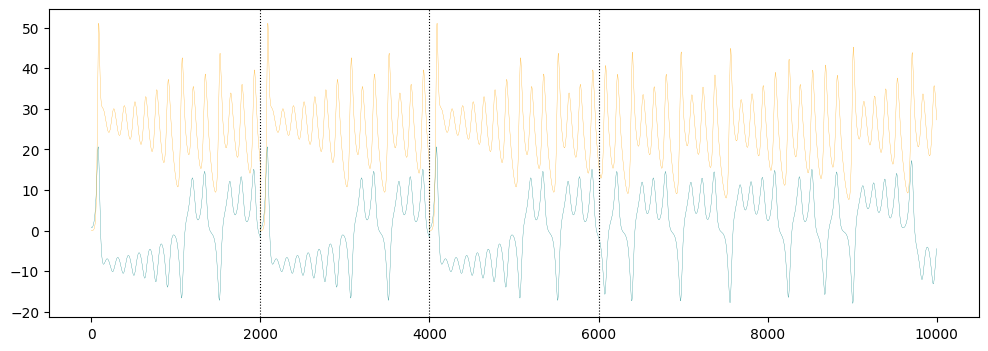

In [6]:
f = plt.plot(xyz_values[n_plot:, 0], lw=0.2, c="teal")
# f = plt.plot(xyz_values[n_plot:, 1], lw=0.2, c="gray")
f = plt.plot(xyz_values[n_plot:, 2], lw=0.2, c="orange")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
axes = plt.gca()
axes.axvline(2000, color="black", lw=0.8, linestyle=":")
axes.axvline(4000, color="black", lw=0.8, linestyle=":")
axes.axvline(6000, color="black", lw=0.8, linestyle=":")

# Looping with Sensitivity to Initial Conditions

The looping behaviour may be made more variable by making use of the sensitivity to initial conditions of the Lorenz system. In this case a controllable perturbation is added to the system's position at the beginning of the loop. This results in loops where the output diverges over the course of the loop, being most similar at first and ending up completely different. Making the perturbation factor larger results in faster deviation from the original trajectory, and smaller results in subtler differences at the end of a loop.

The simulation below shows two cases, one where a relatively small perturbation is applied at the beginning of the loop, and one where a larger perturbation is applied. Setting the perturbation to a very high value is equivalent to moving the starting point a great distance in space from the stored initial coordinates. This is not the same as turning off looping but will result in dissimilar chunks of control voltage.

In these cases, the x,y visualization of the trajectory is not particularly enlightening and only the CV output plots are included.

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

N = 10000
n_plot = 0

lorenz_system = LorenzSystem(timestep=0.006, random_factor=0.05)
looper = Looper(models=[lorenz_system])

xyz_values = np.empty(shape=(N, 3))
xyz_values[0, :] = lorenz_system._coordinates

for i in range(0, 2000):
    xyz_values[i, :] = lorenz_system._coordinates
    looper.take_step()

looper.start_looping()
for i in range(2000, 6000):
    xyz_values[i, :] = lorenz_system._coordinates
    looper.take_step()

looper.stop_looping()
for i in range(6000, N):
    xyz_values[i, :] = lorenz_system._coordinates
    looper.take_step()

# print(xyz_values)

# f = plt.plot(xyz_values[n_plot:, 0], xyz_values[n_plot:, 2], lw=0.1, c="gray")
# f = plt.plot(xyz_values[n_plot:, 0], xyz_values[n_plot:, 1], lw=0.1, c="teal")
# f = plt.plot(xyz_values[n_plot:, 1], xyz_values[n_plot:, 2], lw=0.1, c="orange")

# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(8, 8)

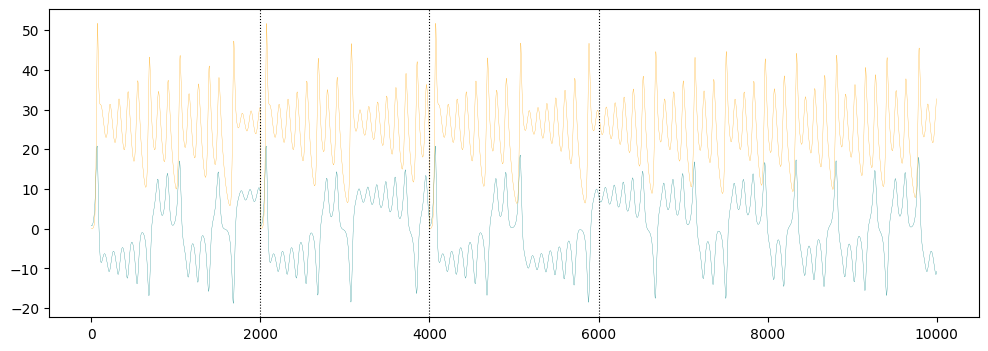

In [8]:
f = plt.plot(xyz_values[n_plot:, 0], lw=0.2, c="teal")
# f = plt.plot(xyz_values[n_plot:, 1], lw=0.2, c="gray")
f = plt.plot(xyz_values[n_plot:, 2], lw=0.2, c="orange")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
axes = plt.gca()
axes.axvline(2000, color="black", lw=0.8, linestyle=":")
axes.axvline(4000, color="black", lw=0.8, linestyle=":")
axes.axvline(6000, color="black", lw=0.8, linestyle=":")
#axes.axvline(8000, color="black", lw=0.5, linestyle=":")
#l = axes.axvline(10000, color="black", lw=0.5, linestyle=":")

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

N = 10000
n_plot = 0

lorenz_system = LorenzSystem(timestep=0.006, random_factor=10)
looper = Looper(models=[lorenz_system])

xyz_values = np.empty(shape=(N, 3))
xyz_values[0, :] = lorenz_system._coordinates

for i in range(0, 2000):
    xyz_values[i, :] = lorenz_system._coordinates
    looper.take_step()

looper.start_looping()
for i in range(2000, 6000):
    xyz_values[i, :] = lorenz_system._coordinates
    looper.take_step()

looper.stop_looping()
for i in range(6000, N):
    xyz_values[i, :] = lorenz_system._coordinates
    looper.take_step()

# # print(xyz_values)

# f = plt.plot(xyz_values[n_plot:, 0], xyz_values[n_plot:, 2], lw=0.1, c="gray")
# f = plt.plot(xyz_values[n_plot:, 0], xyz_values[n_plot:, 1], lw=0.1, c="teal")
# f = plt.plot(xyz_values[n_plot:, 1], xyz_values[n_plot:, 2], lw=0.1, c="orange")

# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(8, 8)

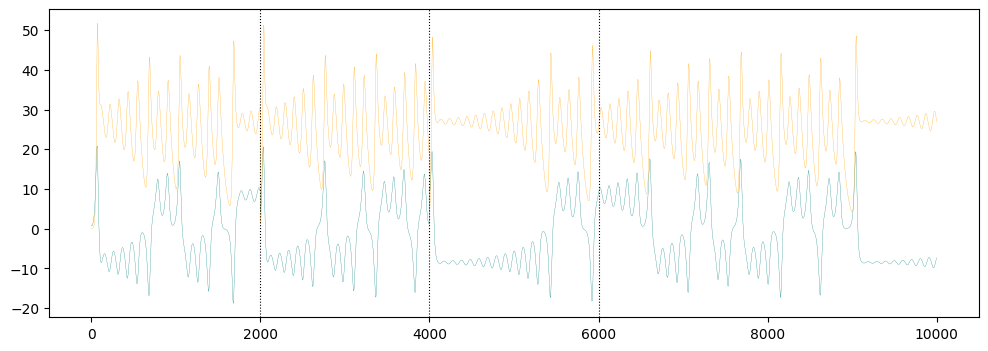

In [10]:
f = plt.plot(xyz_values[n_plot:, 0], lw=0.2, c="teal")
# f = plt.plot(xyz_values[n_plot:, 1], lw=0.2, c="gray")
f = plt.plot(xyz_values[n_plot:, 2], lw=0.2, c="orange")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
axes = plt.gca()
axes.axvline(2000, color="black", lw=0.8, linestyle=":")
axes.axvline(4000, color="black", lw=0.8, linestyle=":")
axes.axvline(6000, color="black", lw=0.8, linestyle=":")
#axes.axvline(8000, color="black", lw=0.5, linestyle=":")
#l = axes.axvline(10000, color="black", lw=0.5, linestyle=":")